In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import *
import json
from glob import glob
from sklearn.manifold import TSNE
from numpy import reshape
from sklearn.decomposition import PCA
import random
import re
import os
from multiprocessing import Pool
import string
from tqdm.auto import tqdm, trange

from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import statsmodels.api as sm
import statsmodels.formula.api as smf
    
from bz2 import BZ2File as bzopen

tqdm.pandas()
    
rng = np.random.default_rng()

In [2]:
with open('', 'r') as f:
    data = json.load(f)

In [ ]:
print(data[0]['comments'][0]['alignments'])

In [ ]:
print(data[0]['spans'][0])

In [12]:
num_processes = os.cpu_count()

In [13]:
def multi_process(num_processes, f, data):
    with Pool(num_processes) as p:
        results = p.map(f, data)
    return results

In [17]:
# which subreddits give the most advice or misalign the most for some appraisal
def ex8_group_level_diff_main(post):
    outputs = []
    
    appraisals = ["Pleasantness", "Anticipated Effort", "Situational Control", "Advice", "Objective Experience", "Self-Other Agency", "Certainty"]

    for node in post['comments']:
        advice_reply = 0
        alignment_dist = {key : {_key : 0 for _key in appraisals} for key in appraisals}
        for alignment in node['alignments']:
            alignment_dist[alignment[0][2]][alignment[1][2]] += 1
            if alignment[1][2] == 'Advice': advice_reply += 1
        outputs.append({
                'subreddit': post['subreddit'],
                'target_spans': post['spans'],
                'observer_spans': node['spans'],
                'alignments': node['alignments'],
                'alignment_dist': alignment_dist,
                'perc_advice_align': advice_reply/len(node['alignments']) if len(node['alignments']) > 0 else -1,
            })
    return outputs

In [18]:
results = multi_process(num_processes, ex8_group_level_diff_main, data)
results = [item for sublist in results for item in sublist]

In [10]:
# for testing
ex8_group_level_diff_main(data[0])

{'Pleasantness': {'Pleasantness': 0, 'Anticipated Effort': 0, 'Situational Control': 0, 'Advice': 0, 'Objective Experience': 0, 'Self-Other Agency': 0, 'Certainty': 0}, 'Anticipated Effort': {'Pleasantness': 0, 'Anticipated Effort': 0, 'Situational Control': 0, 'Advice': 0, 'Objective Experience': 0, 'Self-Other Agency': 0, 'Certainty': 0}, 'Situational Control': {'Pleasantness': 0, 'Anticipated Effort': 0, 'Situational Control': 0, 'Advice': 0, 'Objective Experience': 0, 'Self-Other Agency': 0, 'Certainty': 0}, 'Advice': {'Pleasantness': 0, 'Anticipated Effort': 0, 'Situational Control': 0, 'Advice': 0, 'Objective Experience': 0, 'Self-Other Agency': 0, 'Certainty': 0}, 'Objective Experience': {'Pleasantness': 0, 'Anticipated Effort': 0, 'Situational Control': 0, 'Advice': 0, 'Objective Experience': 0, 'Self-Other Agency': 0, 'Certainty': 0}, 'Self-Other Agency': {'Pleasantness': 0, 'Anticipated Effort': 0, 'Situational Control': 0, 'Advice': 0, 'Objective Experience': 0, 'Self-Other 

In [19]:
len(results)

8891852

In [20]:
with open("", 'w') as outfile:
    outfile.write(json.dumps(results, indent=4))

In [ ]:
# with open("", 'r') as f:
#     results = json.load(f)

### Subreddits giving the most advice

In [24]:
subreddits_all = defaultdict(list)
for result in results:
    if result['perc_advice_align'] != -1:
        subreddits_all[result["subreddit"]].append(result['perc_advice_align'])

In [25]:
# with open("", 'w') as outfile:
#     outfile.write(json.dumps(subreddits_all, indent=4))

In [12]:
with open("", 'r') as f:
    subreddits_all = json.load(f)

In [14]:
subreddits_stats = []
for subreddit, values in subreddits_all.items():
    if len(values) == 0: continue
    subreddits_stats.append([subreddit, 
                             np.mean(np.array(values)), 
                             np.std(np.array(values))/np.sqrt(len(values))])

In [20]:
sort_subreddits = sorted(subreddits_stats, key=lambda x: x[1])
threshold = 10
plot_subreddits = [s[0] for s in sort_subreddits[:threshold]+sorted_subreddits[-1*threshold:]]
plot_mean_lowest = [s[1] for s in sort_subreddits[:threshold]]
plot_stderr_lowest = [s[2] for s in sort_subreddits[:threshold]]
plot_mean_highest = [s[1] for s in sorted_subreddits[-1*threshold:]]
plot_stderr_highest = [s[2] for s in sorted_subreddits[-1*threshold:]]

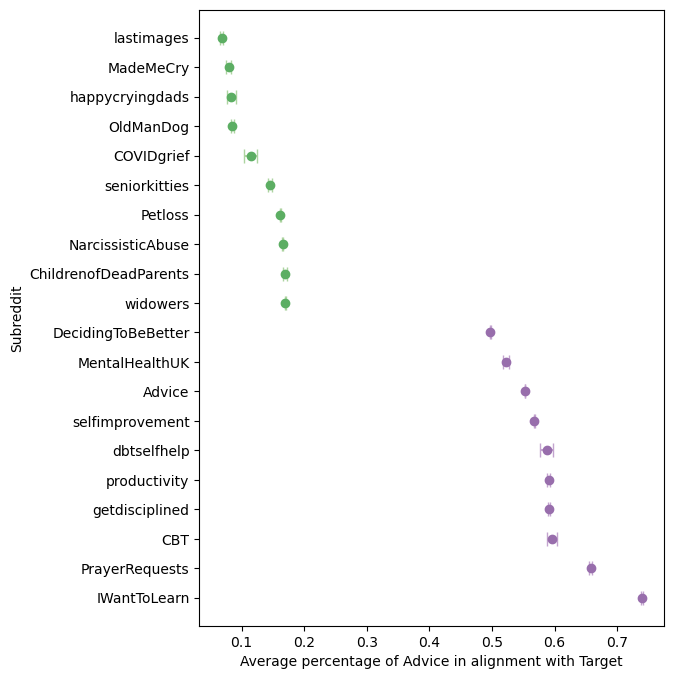

In [22]:
plt.figure(figsize=(6, 8))
plt.errorbar(plot_mean_lowest, range(threshold), xerr=plot_stderr_lowest, fmt='o', capsize=5, ecolor='#ADD4A0', color='#5CAE63')
plt.errorbar(plot_mean_highest, range(threshold, 2*threshold), xerr=plot_stderr_highest, fmt='o', capsize=5, ecolor='#C3A4CF', color='#986EAC')
plt.yticks(range(len(plot_subreddits)), [s for s in plot_subreddits])
plt.xlabel('Average percentage of Advice in alignment with Target')
plt.ylabel('Subreddit')
# plt.title('Means and Standard Deviations')
plt.gca().invert_yaxis()  # Invert y-axis to display data from top to bottom

plt.savefig('', bbox_inches='tight', pad_inches=0.04)

### Misalign for appraisals

In [4]:
appraisals = ["Pleasantness", "Anticipated Effort", "Situational Control", "Advice", "Objective Experience", "Self-Other Agency", "Certainty"]

In [29]:
all_alignment_dist = defaultdict(list)

for result in results:
    misalign_perc = {}
    # calculate the misalignment rate for each appraisal and for each comment
    for appraisal, align in result['alignment_dist'].items():
        misaligned = sum(count for key, count in align.items() if key != appraisal)
        total = sum(count for key, count in align.items())
        misalign_perc[appraisal] = misaligned/total if total != 0 else -1
    all_alignment_dist[result["subreddit"]].append(misalign_perc)

In [30]:
# with open("", 'w') as outfile:
#     outfile.write(json.dumps(all_alignment_dist, indent=4))

In [2]:
with open("", 'r') as f:
    all_alignment_dist = json.load(f)

In [27]:
threshold = 10
for appraisal in appraisals:
    misalign_results = []
    for subreddit, misaligns in all_alignment_dist.items():
        misalign_list = []
        for m in misaligns:
            if m[appraisal] != -1:
                misalign_list.append(m[appraisal])
        misalign_results.append([subreddit, 
                                 np.mean(np.array(misalign_list)), 
                                 np.std(np.array(misalign_list))/len(misalign_list)])
    sorted_misalign = sorted(misalign_results, key=lambda x: x[1]) 
    print(f'----------{appraisal}----------')
#     for s in (sorted_misalign[:threshold]):
#         print(f'{s[0]} {s[1]}')
#     print('|')
#     for s in (sorted_misalign[-1*threshold:]):
#         print(f'{s[0]} {s[1]}')
    
    print(", ".join([s[0] for s in sorted_misalign[-1*threshold:]]))
    print(", ".join([s[0] for s in sorted_misalign[:threshold]]))

----------Pleasantness----------
selfimprovement, getdisciplined, productivity, socialskills, askfuneraldirectors, CBT, Advice, PrayerRequests, IWantToLearn, AskPsychiatry
MadeMeCry, COVIDgrief, lastimages, Petloss, Miscarriage, GriefSupport, Grieving, widowers, happycryingdads, grief
----------Anticipated Effort----------
gaslighting, sad, happycryingdads, marriageadvice, narcissism, IWantToLearn, askatherapist, askfuneraldirectors, Advice, AskPsychiatry
CPTSDNextSteps, ttcafterloss, FriendsOver40, widowers, PregnancyAfterLoss, BPDlite, Miscarriage, cptsdcreatives, CPTSD, MadeMeCry
----------Situational Control----------
dbtselfhelp, MomForAMinute, NarcAbuseAndDivorce, psychotherapy, IWantToLearn, BodyAcceptance, marriageadvice, Advice, askfuneraldirectors, PrayerRequests
BPDlite, happycryingdads, CPTSD, widowers, Anxiety, BPD, ChildrenofDeadParents, depression, COVIDgrief, SuicideBereavement
----------Advice----------
CPTSDNextSteps, BorderlinePDisorder, BPD4BPD, widowers, Narcissist